In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf

In [2]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
data_path = "H:\\AICUP\\trainset"
os.path.exists(data_path)

True

In [4]:
def DataList(data_path):
  img_list, data_label, data_types = [], [], []
  class_path = ""
  for root, dirs, files in os.walk(data_path):
    if root.split("\\")[-1]!="model-logs":
      for file in files:
        if file.find("checkpoint")==-1:
          if file[-3:]=="csv":
            #class_path = os.path.join(root, file)
            class_path=root+"\\"+file
          else:
            #img_list.append(os.path.join(root, file))
            img_list.append(root+"\\"+file)
            label = root.split("\\")[-1]
            types = root.split("\\")[-2]
            data_label.append(label)
            data_types.append(types)
  data_list = pd.DataFrame({"img_path":img_list, "label_name":data_label, "types":data_types})
  
  if class_path != "":
    class_map = pd.read_csv(class_path, header=None)
    class_map = dict(class_map.values)
  else:
    class_map = data_list[data_list["types"]=="train"]["label_name"].unique()
    class_map = {label: str(i) for i, label in enumerate(class_map)}
    print(class_map)

  data_list["label"] = data_list["label_name"].map(class_map)
  
  train_list = data_list[data_list["types"]=="train"][["img_path", "label_name", "label"]].copy()
  valid_list = data_list[data_list["types"]=="valid"][["img_path", "label_name", "label"]].copy()
  test_list = data_list[data_list["types"]=="test"][["img_path", "label_name", "label"]].copy()

  return train_list, valid_list, test_list, class_map

In [5]:
train_list, valid_list, test_list, class_map = DataList(data_path)

{'asparagus': '0', 'bambooshoots': '1', 'betel': '2', 'broccoli': '3', 'cauliflower': '4', 'chinesecabbage': '5', 'chinesechives': '6', 'custardapple': '7', 'grape': '8', 'greenhouse': '9', 'greenonion': '10', 'kale': '11', 'lemon': '12', 'lettuce': '13', 'litchi': '14', 'longan': '15', 'loofah': '16', 'mango': '17', 'onion': '18', 'others': '19', 'papaya': '20', 'passionfruit': '21', 'pear': '22', 'pennisetum': '23', 'redbeans': '24', 'roseapple': '25', 'sesbania': '26', 'soybeans': '27', 'sunhemp': '28', 'sweetpotato': '29', 'taro': '30', 'tea': '31', 'waterbamboo': '32'}


In [6]:
train_list

,img_path,label_name,label
224,H:\AICUP\trainset\train\asparagus\000b43a3-d33...,asparagus,0
225,H:\AICUP\trainset\train\asparagus\00172189-315...,asparagus,0
226,H:\AICUP\trainset\train\asparagus\002aec7b-648...,asparagus,0
227,H:\AICUP\trainset\train\asparagus\007cd63a-333...,asparagus,0
228,H:\AICUP\trainset\train\asparagus\00a326ba-7e9...,asparagus,0
...,...,...,...
89285,H:\AICUP\trainset\train\waterbamboo\ffb5fc02-3...,waterbamboo,32
89286,H:\AICUP\trainset\train\waterbamboo\ffd7568f-f...,waterbamboo,32
89287,H:\AICUP\trainset\train\waterbamboo\ffd9c5f8-e...,waterbamboo,32
89288,H:\AICUP\trainset\train\waterbamboo\fff0cfff-8...,waterbamboo,32


In [11]:
# class_map={'asparagus':0,'bambooshoots':1,'betel':2,'broccoli':3,'cauliflower':4,'chinesecabbage':5,'chinesechives':6,
#                'custardapple':7,'grape':8,'greenhouse':9,'greenonion':10,'kale':11,'lemon':12,'lettuce':13,'litchi':14,
#                'longan':15,'loofah':16,'mango':17,'onion':18,'others':19,'papaya':20,'passionfruit':21,'pear':22,
#                'pennisetum':23,'redbeans':24,'roseapple':25,'sesbania':26,'soybeans':27,'sunhemp':28,'sweetpotato':29,
#                'taro':30,'tea':31,'waterbamboo':32}
class_map_new={'others':0,'not-others':1}

In [12]:
test_list[test_list["label"]=='0']

,img_path,label_name,label
0,H:\AICUP\trainset\test\asparagus\3abbbebd-c08f...,asparagus,0
1,H:\AICUP\trainset\test\asparagus\4d54439f-66b5...,asparagus,0
2,H:\AICUP\trainset\test\asparagus\606d9665-533a...,asparagus,0
3,H:\AICUP\trainset\test\asparagus\69e455f3-fd93...,asparagus,0
4,H:\AICUP\trainset\test\asparagus\a4e09409-ccd7...,asparagus,0


In [46]:
#evenly extract classes from 32 classes except others
train_list_new=train_list[train_list["label"]==0].head(70)#2217/32
valid_list_new=valid_list[valid_list['label']==0]
test_list_new=test_list[test_list['label']==0]
for i in range(19):
    label=str(i)
    t=train_list[train_list["label"]==label].head(70)
    train_list_new=pd.concat([train_list_new,t])
    v=valid_list[valid_list["label"]==label]
    valid_list_new=pd.concat([valid_list_new,v])
    test=test_list[test_list["label"]==label]
    test_list_new=pd.concat([test_list_new,test])
t=train_list[train_list["label"]=='19']
train_list_new=pd.concat([train_list_new,t])
v=valid_list[valid_list["label"]=='19']
valid_list_new=pd.concat([valid_list_new,v])
test=test_list[test_list["label"]=='19']
test_list_new=pd.concat([test_list_new,test])
for i in range(20,33):
    label=str(i)
    t=train_list[train_list["label"]==label].head(70)
    train_list_new=pd.concat([train_list_new,t])
    v=valid_list[valid_list["label"]==label]
    valid_list_new=pd.concat([valid_list_new,v])
    test=test_list[test_list["label"]==label]
    test_list_new=pd.concat([test_list_new,test])
print(train_list_new)
print(valid_list_new)
print(test_list_new)

                                                img_path   label_name label
224    H:\AICUP\trainset\train\asparagus\000b43a3-d33...    asparagus     0
225    H:\AICUP\trainset\train\asparagus\00172189-315...    asparagus     0
226    H:\AICUP\trainset\train\asparagus\002aec7b-648...    asparagus     0
227    H:\AICUP\trainset\train\asparagus\007cd63a-333...    asparagus     0
228    H:\AICUP\trainset\train\asparagus\00a326ba-7e9...    asparagus     0
...                                                  ...          ...   ...
86176  H:\AICUP\trainset\train\waterbamboo\05f05c46-a...  waterbamboo    32
86177  H:\AICUP\trainset\train\waterbamboo\06140f8f-6...  waterbamboo    32
86178  H:\AICUP\trainset\train\waterbamboo\0640fcb3-8...  waterbamboo    32
86179  H:\AICUP\trainset\train\waterbamboo\0671961c-b...  waterbamboo    32
86180  H:\AICUP\trainset\train\waterbamboo\0672a9d3-c...  waterbamboo    32

[4457 rows x 3 columns]
                                                img_path   labe

In [47]:
#replace label
for i in range(19):
    label=str(i)
    train_list_new=train_list_new.replace(["19",label],['0','1'])
    valid_list_new=valid_list_new.replace(["19",label],['0','1'])
    test_list_new=test_list_new.replace(["19",label],['0','1'])
for i in range(20,33):
    label=str(i)
    train_list_new=train_list_new.replace([label],['1'])
    valid_list_new=valid_list_new.replace([label],['1'])
    test_list_new=test_list_new.replace([label],['1'])
train_list_new.sort_values(by=['label'])
valid_list_new.sort_values(by=['label'])
test_list_new.sort_values(by=['label'])

,img_path,label_name,label
127,H:\AICUP\trainset\test\others\79957154-9d38-43...,others,0
130,H:\AICUP\trainset\test\others\f70ba4a5-4124-41...,others,0
129,H:\AICUP\trainset\test\others\ba964482-7e16-49...,others,0
128,H:\AICUP\trainset\test\others\90c385b5-1c5f-44...,others,0
126,H:\AICUP\trainset\test\others\148402c9-963a-4e...,others,0
...,...,...,...
79,H:\AICUP\trainset\test\kale\8f78071b-4a20-49ba...,kale,1
80,H:\AICUP\trainset\test\kale\9a8d7cf2-a9ef-4db6...,kale,1
81,H:\AICUP\trainset\test\kale\af8e33a7-bbe8-4569...,kale,1
222,H:\AICUP\trainset\test\waterbamboo\b48469f0-0d...,waterbamboo,1


In [48]:
train_list_new[train_list_new['label']=='0']

,img_path,label_name,label
49954,H:\AICUP\trainset\train\others\000950a5-6802-4...,others,0
49955,H:\AICUP\trainset\train\others\0030a0ea-acb3-4...,others,0
49956,H:\AICUP\trainset\train\others\003d3969-9f03-4...,others,0
49957,H:\AICUP\trainset\train\others\0046e995-33b2-4...,others,0
49958,H:\AICUP\trainset\train\others\00519286-35df-4...,others,0
...,...,...,...
52166,H:\AICUP\trainset\train\others\ff28006c-b999-4...,others,0
52167,H:\AICUP\trainset\train\others\ff32a8b2-881e-4...,others,0
52168,H:\AICUP\trainset\train\others\ff583d7e-734f-4...,others,0
52169,H:\AICUP\trainset\train\others\ff9bfa02-2575-4...,others,0


In [49]:
class_map_new.keys()
#class_map.keys()

dict_keys(['others', 'not-others'])

In [50]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [51]:
#num_classes = train_list_new["label"].unique().shape[0]
num_classes = train_list_new["label"].unique().shape[0]
num_classes

2

In [52]:
img_shape = (400,400)
batch_size = 8

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [54]:
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input

In [55]:
def HSV(image):
    image = np.array(image)
    image=cv2.detailEnhance(image, sigma_s=100, sigma_r=0.1) #細節增強
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(hsv_image)
    # 亮度(V)
    v = V.ravel()[np.flatnonzero(V)]
    aver_v = sum(v)/len(v)
#     print(aver_v)
    
    if aver_v > 140:
        hsv_image=tf.image.adjust_brightness(hsv_image,0.4) #亮度
    else:
        hsv_image=tf.image.adjust_brightness(hsv_image,-0.1)

    hsv_image=tf.image.adjust_saturation(hsv_image,0.5) #飽和度
    
    
#    hsv_image = cv2.cvtColor(hsv_image,cv2.COLOR_HSV2RGB)
    return preprocess_input(np.uint8(hsv_image))
#    return Image.fromarray(np.uint8(hsv_image))

In [56]:
train_datagen = ImageDataGenerator(
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.2,
                    preprocessing_function=preprocess_input
                    )
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [57]:
train_generator = train_datagen.flow_from_dataframe(
                              dataframe=train_list_new,#need to be changed
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical')
valid_generator = valid_datagen.flow_from_dataframe(
                              dataframe=valid_list_new,#need to be changed
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical',
                              shuffle=False)
test_generator = test_datagen.flow_from_dataframe(
                              dataframe=test_list_new,#need to be changed
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode=None,
                              shuffle=False)

Found 4457 validated image filenames belonging to 2 classes.
Found 224 validated image filenames belonging to 2 classes.
Found 224 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 400, 400, 3)
(400, 400, 3) 1.0 -1.0


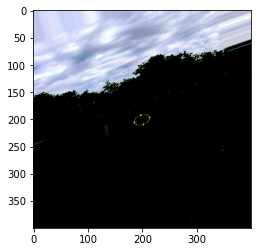

In [58]:
(data_train,label_train)= train_generator.next()
print(data_train.shape)
img=data_train[-1,:,:,:]
img=img
print(img.shape,img.max(),img.min())
plt.imshow(img)

In [59]:
pre_model = InceptionV3(weights='imagenet', input_shape=(img_shape[0], img_shape[1], 3), include_top=False)

x = layers.AveragePooling2D()(pre_model.output)
x=layers.Flatten()(x)
# x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

In [60]:
model = keras.models.Model(inputs=pre_model.inputs, outputs=outputs)

In [61]:
def lr_schedule(epoch):
    lrate=0.001
    if epoch>10:
        lrate=0.0005
    if epoch>20:
        lrate=0.0001
    return lrate

In [62]:
import tensorflow as tf

model_dir = os.path.join(data_path, 'model-logs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model-test000.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)
reduce_lr=callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                      patience=10,min_lr=0.001,
                                      verbose=0,mode='auto',
                                      min_delta=0.001,cooldown=0)
import datetime
logdir=os.path.join(data_path,'logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback=tf.keras.callbacks.TensorBoard(logdir,
                                                    histogram_freq=1,
                                                    write_images=True,
                                                    embeddings_freq=1)

lrschedule=tf.keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks_list = [model_mckp,lrschedule]

In [63]:
def num_steps_per_epoch(data_generator, batch_size):
    if data_generator.n % batch_size==0:
        return data_generator.n//batch_size
    else:
        return data_generator.n//batch_size + 1

In [64]:
lr = 1e-3
batch_size = 8
num_epochs = 10

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [65]:
optimizer = keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [66]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 199, 199, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 199, 199, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_5 (BatchNo  (None, 47, 47, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 47, 47, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 47, 47, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 47, 47, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 47, 47, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 47, 47, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 47, 47, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 47, 47, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 23, 23, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 23, 23, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 23, 23, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 23, 23, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 23, 23, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 23, 23, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 23, 23, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 23, 23, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 23, 23, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 23, 23, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 23, 23, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 23, 23, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 23, 23, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 23, 23, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 23, 23, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 23, 23, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 23, 23, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 23, 23, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 23, 23, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 23, 23, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 11, 11, 320)  960        ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 11, 11, 384)  0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 11, 11, 384)  0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 11, 11, 384)  0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 11, 11, 384)  0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 11, 11, 384)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 11, 11, 384)  0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 11, 11, 192)  576        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 11, 11, 320)  0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [67]:
pre_model.trainable = False

In [68]:
history = model.fit(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list)

Epoch 1/10
558/558 [==============================] - 289s 509ms/step - loss: 0.7596 - accuracy: 0.6213 - val_loss: 0.4402 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 2/10
558/558 [==============================] - 136s 244ms/step - loss: 0.5374 - accuracy: 0.7404 - val_loss: 0.4890 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 3/10
558/558 [==============================] - 134s 240ms/step - loss: 0.5574 - accuracy: 0.7458 - val_loss: 2.4417 - val_accuracy: 0.5134 - lr: 0.0010
Epoch 4/10
558/558 [==============================] - 141s 252ms/step - loss: 0.6559 - accuracy: 0.7157 - val_loss: 0.2348 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 5/10
558/558 [==============================] - 137s 245ms/step - loss: 0.5216 - accuracy: 0.7510 - val_loss: 0.3714 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 6/10
558/558 [==============================] - 139s 249ms/step - loss: 0.5163 - accuracy: 0.7586 - val_loss: 0.3926 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 7/10
558/558 [==========================

In [69]:
pre_model.trainable = True
for each_layer in pre_model.layers[:-5]: #倒數五層
    each_layer.trainable = False

batch_size = 8
num_epochs = 20

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [70]:
history = model.fit(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list,
                  initial_epoch=10)

Epoch 11/20
558/558 [==============================] - 128s 230ms/step - loss: 0.5298 - accuracy: 0.7427 - val_loss: 0.5076 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 12/20
558/558 [==============================] - 129s 230ms/step - loss: 0.5201 - accuracy: 0.7584 - val_loss: 0.4076 - val_accuracy: 0.7946 - lr: 5.0000e-04
Epoch 13/20
558/558 [==============================] - 128s 230ms/step - loss: 0.5058 - accuracy: 0.7655 - val_loss: 0.4210 - val_accuracy: 0.7991 - lr: 5.0000e-04
Epoch 14/20
558/558 [==============================] - 130s 232ms/step - loss: 0.4967 - accuracy: 0.7611 - val_loss: 0.5450 - val_accuracy: 0.7500 - lr: 5.0000e-04
Epoch 15/20
558/558 [==============================] - 129s 230ms/step - loss: 0.5003 - accuracy: 0.7631 - val_loss: 0.4441 - val_accuracy: 0.7991 - lr: 5.0000e-04
Epoch 16/20
558/558 [==============================] - 129s 231ms/step - loss: 0.4881 - accuracy: 0.7694 - val_loss: 0.5137 - val_accuracy: 0.7455 - lr: 5.0000e-04
Epoch 17/20
558/558 

In [71]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [72]:
from keras.models import model_from_json
import keras

In [73]:
# model=keras.models.load_model('F:\\AICUP\\trainset_400\\model-logs\\others_400(0.794).h5')
# model.summary()

In [74]:
batch_size = 8
test_steps = num_steps_per_epoch(test_generator, batch_size)

In [75]:
y_test = test_list_new["label"].values.astype(np.int_)#need to be changed
#y_test=np.transpose(test_generator.labels)

In [76]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [77]:
y_test_predprob = model.predict(test_generator,verbose=1)
y_test_pred = y_test_predprob.argmax(-1)

28/28 [==============================] - 11s 370ms/step


In [78]:
y_test_pred

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int64)

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy_score: 0.848


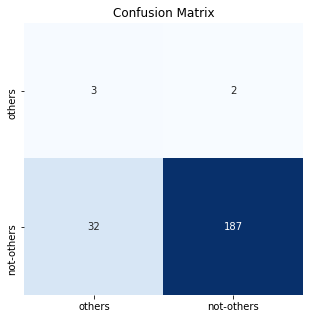

In [80]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False,
      xticklabels=class_map_new.keys(), yticklabels=class_map_new.keys())
plt.title("Confusion Matrix")
plt.show()

In [81]:
from  sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.09      0.60      0.15         5
           1       0.99      0.85      0.92       219

    accuracy                           0.85       224
   macro avg       0.54      0.73      0.53       224
weighted avg       0.97      0.85      0.90       224



In [72]:
model.save('F:\\AICUP\\trainset_400\\model-logs\\others_Densenet121(0.848).h5')